In [23]:
import networkx as nx
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

# Some useful functions

In [24]:
def all_gammas(n, Es, adjlist, idx, adjlist_labels):
    
    gammas_intra = []
    gammas_inter = []
    
    for i in range(n):
                                 
        psi_function = Es[idx[i]:idx[i] + len(adjlist[i])]
        temp = psi_function - (psi_function).max()
        ex = np.exp(temp)
        gammas_gat = ex / np.sum(ex)          
        gammas_intra.append(list(gammas_gat[adjlist_labels[idx[i]:idx[i] + len(adjlist[i])]]))
        gammas_inter.append(list(gammas_gat[list(~np.array(adjlist_labels[idx[i]:idx[i] + len(adjlist[i])]))]))
        
        gammas_gcn = np.ones(len(adjlist[i]))/len(adjlist[i])
            
    return gammas_intra, gammas_inter

# Create data positive result

In [25]:
n = 400
d = int(np.ceil(n/(np.log(n)**2)))
p = 0.4

sizes = [int(n/2), int(n/2)]

zeta = 0.1

p = 0.4`
q = 0.33

nu_up = 30*zeta*np.sqrt(np.log(0.5*n**2*(p+q)))/(2*np.sqrt(d))
nu_lb = 0.01*zeta*np.sqrt(np.log(0.5*n**2*(p+q)))/(2*np.sqrt(d))
nus = np.geomspace(nu_lb, nu_up, 30, endpoint=True)

ground_truth = np.concatenate((np.zeros(int(n/2)), np.ones(int(n/2))))

avg_gammas_intra = []
std_gammas_intra = []

avg_gammas_inter = []
std_gammas_inter = []

trials = 50

for nu in nus:
    
    print(nu/nus[-1])
    
    probs = [[p,q], [q,p]]
    
    all_gammas_intra = []
    all_gammas_inter = []
    
    for trial in range(trials):
        g = nx.stochastic_block_model(sizes, probs)

        adjlist = [[v for v in g.neighbors(i)] for i in range(n)]
        tmp = [[ground_truth[v] == ground_truth[i] for v in g.neighbors(i)] for i in range(n)]
        adjlist_labels = []
        for i in range(n):
            adjlist_labels += tmp[i]
        adjlist_labels = np.asarray(adjlist_labels)
        m = len(adjlist_labels)
        idx = np.zeros(n, dtype=int)
        for i in range(n-1):
            idx[i+1] = idx[i] + len(adjlist[i])
        
        E = nu*np.ones(m*d)
        E = np.reshape(E, (m,d))*(2*adjlist_labels[:, np.newaxis]-1)
        noise = zeta*np.random.randn(m,d)
        E = E + noise
        
        R = 1
        nu_ = nu*np.ones(d)
        s = np.sign(p-q)*(R/np.linalg.norm(nu_))*nu_
        Es = E@s

        gammas_intra, gammas_inter = all_gammas(n, Es, adjlist, idx, adjlist_labels)  
        
        [all_gammas_intra.extend(tmp) for tmp in gammas_intra] 
        [all_gammas_inter.extend(tmp) for tmp in gammas_inter] 
    
    avg_gammas_intra.append(np.asarray(all_gammas_intra).mean())
    std_gammas_intra.append(np.asarray(all_gammas_intra).std())
    
    avg_gammas_inter.append(np.asarray(all_gammas_inter).mean())
    std_gammas_inter.append(np.asarray(all_gammas_inter).std())
    

0.0003333333333333333
0.00043931848595550247
0.0005790021963067057
0.0007630991047391176
0.0010057306299839665
0.0013255081729308894
0.00174696073096093
0.0023024164300484208
0.0030344823002638353
0.003999312509432035
0.005270915749519754
0.0069468321800341
0.009155615386558628
0.01206669326884152
0.01590336425207073
0.020959925714455735
0.0276242484918435
0.03640752906928579
0.04798350164429873
0.06324011787965012
0.08334765851560616
0.10984850144103711
0.14477543201267176
0.19080757078608224
0.2514758793197672
0.3314340076712664
0.4368152593329158
0.5757030551171902
0.7587509836021236
1.0


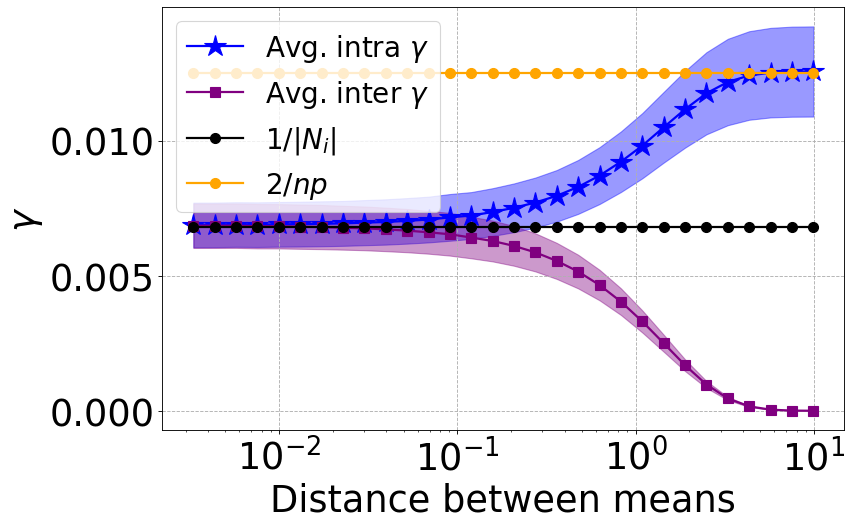

In [39]:
fig = plt.figure(figsize=(11, 7), dpi=80)

val = (2*np.sqrt(d))
plt.plot(nus*val,avg_gammas_intra, linewidth=2, linestyle='-', marker='*', markersize=20,  label='Avg. intra $\gamma$', color = 'blue')
plt.fill_between(nus*val,np.asarray(avg_gammas_intra)-np.asarray(std_gammas_intra),np.minimum(np.asarray(avg_gammas_intra)+np.asarray(std_gammas_intra),1),alpha=0.4, color = 'blue')

plt.plot(nus*val,avg_gammas_inter, linewidth=2, linestyle='-', marker='s', markersize=9,  label='Avg. inter $\gamma$', color = 'purple')
plt.fill_between(nus*val,np.asarray(avg_gammas_inter)-np.asarray(std_gammas_inter),np.minimum(np.asarray(avg_gammas_inter)+np.asarray(std_gammas_inter),1),alpha=0.4, color = 'purple')

gammas_gcn = 1/(1+0.5*n*(p+q))
    
plt.plot(nus*val,gammas_gcn*np.ones(len(nus)), linewidth=2, linestyle='-', marker='o', markersize=9, color = 'black', label='$1/|N_i|$')

plt.plot(nus*val,(2/(n*p))*np.ones(len(nus)), linewidth=2, linestyle='-', marker='o', markersize=9, color = 'orange', label='$2/np$')

plt.grid(linestyle='dashed')
plt.legend(fontsize=25, loc='upper left')
plt.xscale('log')
plt.tick_params(axis='x', labelsize=33)
plt.tick_params(axis='y', labelsize=33)
plt.xlabel('Distance between means', fontsize=33)
plt.ylabel('$\gamma$', fontsize=33)

fig.savefig("figures/varying_distance_of_edge_features_gammas.pdf", dpi=400, bbox_inches='tight')